## DOWNSTREAM SIGNALING DYNAMICS

## PCA

In [52]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from msresist.pca import pca_dfs

In [53]:
# Set plotting format
matplotlib.rcParams['font.sans-serif'] = "Arial"
sns.set(style="whitegrid", font_scale=1, color_codes=True, palette="colorblind", rc={"grid.linestyle": "dotted", "axes.linewidth": 0.6})

In [57]:
def plotPCA(ax, d, n_components, scores_ind, loadings_ind, hue_scores=None, style_scores=None, size_dots=100, pvals=None, style_load=None, legendOut=False, quadrants=True):
    """ Plot PCA scores and loadings. """
    pp = PCA(n_components=n_components)
    dScor_ = pp.fit_transform(d.select_dtypes(include=["float64"]))
    dLoad_ = pp.components_
    dScor_, dLoad_ = pca_dfs(dScor_, dLoad_, d, n_components, scores_ind, loadings_ind)
    varExp = np.round(pp.explained_variance_ratio_, 2)

    # Scores
    sns.scatterplot(x="PC1", y="PC2", data=dScor_, hue=hue_scores, style=style_scores, ax=ax[0], **{"linewidth": 0.5, "edgecolor": "k"}, s=size_dots)
    ax[0].set_title("PCA Scores")
    ax[0].set_xlabel("PC1 (" + str(int(varExp[0] * 100)) + "%)", fontsize=10)
    ax[0].set_ylabel("PC2 (" + str(int(varExp[1] * 100)) + "%)", fontsize=10)
    ax[0].legend(prop={'size': 8})
    if legendOut:
        ax[0].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, labelspacing=0.2, prop={'size': 8})

    # Loadings
    if isinstance(pvals, np.ndarray):
        dLoad_["p-value"] = pvals
        sns.scatterplot(x="PC1", y="PC2", data=dLoad_, hue="p-value", style=style_load, ax=ax[1], **{"linewidth": 0.5, "edgecolor": "k"}, s=100)
    else:
        sns.scatterplot(x="PC1", y="PC2", data=dLoad_, style=style_load, ax=ax[1], **{"linewidth": 0.5, "edgecolor": "k"}, s=100)

    ax[1].set_title("PCA Loadings")
    ax[1].set_xlabel("PC1 (" + str(int(varExp[0] * 100)) + "%)", fontsize=10)
    ax[1].set_ylabel("PC2 (" + str(int(varExp[1] * 100)) + "%)", fontsize=10)
    ax[1].legend(prop={'size': 8})
    for j, txt in enumerate(dLoad_[loadings_ind]):
        ax[1].annotate(txt, (dLoad_["PC1"][j] + 0.001, dLoad_["PC2"][j] + 0.001), fontsize=10)

    if quadrants:
        ax[0].axhline(0, ls='--', color='lightgrey')
        ax[0].axvline(0, ls='--', color='lightgrey')
        ax[1].axhline(0, ls='--', color='lightgrey')
        ax[1].axvline(0, ls='--', color='lightgrey')

In [58]:
ts = pd.read_csv("msresist/data/Validations/Luminex/AXLm_TimeSeries_Downstream.csv")
ts.iloc[:, 3:] = pd.DataFrame(StandardScaler().fit_transform(ts.iloc[:, 3:]))
ts["Time point"] = ts["Time point"].replace(0, 1)
# ts["Time point"] = ts["Time point"].replace(5, 50)
# ts["Time point"] = ts["Time point"].replace(10, 100)
# ts["Time point"] = ts["Time point"].replace(30, 150)
# ts["Time point"] = ts["Time point"].replace(60, 250)
# ts["Time point"] = ts["Time point"].replace(120, 350)
# ts["Time point"] = ts["Time point"].replace(240, 450)

ts = ts.set_index("Cell Line")
for cl, idx in list(zip(ts.index.values, np.arange(ts.shape[0]))):
    ts.iloc[idx, 2:] /= ts.loc[cl].iloc[0, 2:]
ts = ts.reset_index()

In [ ]:
# ts = ts.reset_index().set_index("Treatment").drop("UT").reset_index()
# ts.iloc[:, 3:] = StandardScaler(with_std=False).fit_transform(ts.iloc[:, 3:])

No handles with labels found to put in legend.


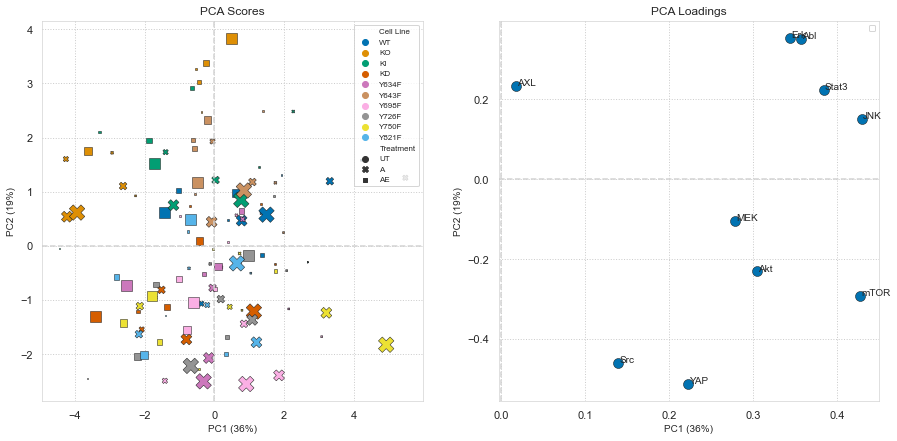

In [59]:
_, ax = plt.subplots(1, 2, figsize=(15, 7))
plotPCA(ax, ts, 2, ["Cell Line", "Treatment"], ts.columns[3:], hue_scores="Cell Line", style_scores="Treatment", size_dots=list(ts["Time point"]))

## TENSOR DECOMPOSITION

In [60]:
a = ts[(ts["Treatment"] == "UT") | (ts["Treatment"] == "A")].iloc[:, 3:].values.reshape((10, 7, 10))
ae = ts[(ts["Treatment"] == "UT") | (ts["Treatment"] == "AE")].iloc[:, 3:].values.reshape((10, 7, 10))
out = np.array([a, ae])
print(out.shape)

(2, 10, 7, 10)


In [61]:
from tensorly.decomposition import parafac
import tensorly as tl

fac = parafac(out, 2, tol=1e-9, n_iter_max=1000)
fac = tl.cp_tensor.cp_flip_sign(fac)

In [62]:
# data variance
dvar = np.sum(np.square(out))
diffvar = np.sum(np.square(out - tl.cp_to_tensor(fac)))

# R2X
print(1.0 - diffvar / dvar)

0.3152800063141106


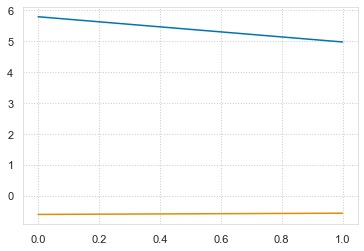

In [63]:
# First mode factors
plt.plot(fac.factors[0]);

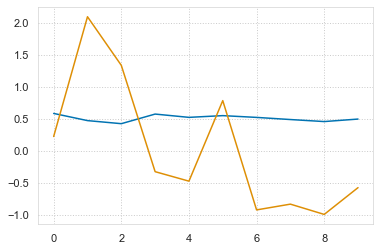

In [64]:
# Second mode factors
plt.plot(fac.factors[1]);

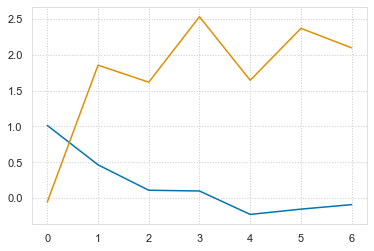

In [65]:
# Third mode factors
plt.plot(fac.factors[2]);